In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 1. Project Setup
import sys
PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added to sys.path")
print(sys.path[:3])


# 2. Strict Seeding (Includes DataLoader Workers)
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Ensure deterministic algorithms (might be slower, but reproducible)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Generator for DataLoaders (Fix 3)
g_cuda = torch.Generator()
g_cuda.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

print(f"✅ Environment set. Root: {PROJECT_ROOT}, Seed: {SEED}")

Mounted at /content/drive
Project root added to sys.path
['/content/drive/MyDrive/MIG_Uncertainty_Project', '/content', '/env/python']
✅ Environment set. Root: /content/drive/MyDrive/MIG_Uncertainty_Project, Seed: 42


In [2]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/models/backbone.py
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # --- ENCODER ---
        # Input: (Batch, 1, 256)
        self.encoder = nn.Sequential(
            # Layer 1: 256 -> 128
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Layer 2: 128 -> 64
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        # --- DECODER ---
        # Input: (Batch, 64, 64)
        self.decoder = nn.Sequential(
            # Layer 1: 64 -> 128 (Kernel=2, Stride=2 acts as perfect 2x upsampler)
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(True),

            # Layer 2: 128 -> 256
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid() # Force [0, 1] range
        )

    def forward(self, x):
        # Explicit Shape Check (Fix 1)
        original_len = x.shape[-1]

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # Safety Assertion: If this fails, the architecture is wrong for the input size
        assert decoded.shape[-1] == original_len, \
            f"Shape Mismatch! Input: {original_len}, Output: {decoded.shape[-1]}"

        return decoded

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/models/backbone.py


In [3]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/utils/data_loader.py
import torch
from torch.utils.data import Dataset
import numpy as np

class NoisyECGDataset(Dataset):
    def __init__(self, clean_data_path, noise_level=0.1, mask_prob=0.0):
        self.clean_data = torch.load(clean_data_path)
        self.noise_level = noise_level
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        clean = self.clean_data[idx]

        # 1. Add Gaussian Noise
        noise = torch.randn_like(clean) * self.noise_level
        noisy = clean + noise

        # 2. Add Random Masking
        if self.mask_prob > 0:
            if torch.rand(1).item() < 0.5:
                mask_len = int(clean.shape[-1] * 0.1)
                start = torch.randint(0, clean.shape[-1] - mask_len, (1,)).item()
                noisy[:, start : start + mask_len] = 0.0

        noisy = torch.clamp(noisy, 0.0, 1.0)
        return noisy, clean

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/utils/data_loader.py


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import json

# Import the modules we just wrote
from models.backbone import ConvAutoencoder
from utils.data_loader import NoisyECGDataset

# --- CONFIGURATION LOGGING (Fix 2) ---
CONFIG = {
    "seed": SEED,
    "batch_size": 64,
    "epochs": 20,
    "lr": 0.001,
    "noise_level": 0.1,
    "mask_prob": 0.1,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "architecture": "ConvAutoencoder_1D_Baseline"
}

# Paths
TRAIN_PATH = os.path.join(PROJECT_ROOT, "data/processed/train_clean.pt")
VAL_PATH = os.path.join(PROJECT_ROOT, "data/processed/val_clean.pt")
SAVE_DIR = os.path.join(PROJECT_ROOT, "results/models")
os.makedirs(SAVE_DIR, exist_ok=True)

# Datasets
train_dataset = NoisyECGDataset(TRAIN_PATH, noise_level=CONFIG['noise_level'], mask_prob=CONFIG['mask_prob'])
val_dataset = NoisyECGDataset(VAL_PATH, noise_level=CONFIG['noise_level'], mask_prob=CONFIG['mask_prob'])

# Loaders with Reproducibility Workers (Fix 3)
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g_cuda
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=g_cuda
)

print("✅ Configuration locked:", CONFIG)

✅ Configuration locked: {'seed': 42, 'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'noise_level': 0.1, 'mask_prob': 0.1, 'device': 'cuda', 'architecture': 'ConvAutoencoder_1D_Baseline'}


In [5]:
model = ConvAutoencoder().to(CONFIG['device'])
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])

train_losses = []
val_losses = []
best_val_loss = float('inf')

print(f"🚀 Starting Training on {CONFIG['device']}...")

for epoch in range(CONFIG['epochs']):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(CONFIG['device']), clean.to(CONFIG['device'])

        optimizer.zero_grad()
        output = model(noisy) # Assertion inside model checks shapes automatically
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATE ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(CONFIG['device']), clean.to(CONFIG['device'])
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # --- SAVE ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save Model
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "baseline_ae.pth"))
        # Save Config (Fix 2)
        with open(os.path.join(SAVE_DIR, "baseline_config.json"), "w") as f:
            json.dump(CONFIG, f, indent=4)
        saved_msg = "💾 Saved"
    else:
        saved_msg = ""

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | {saved_msg}")

print("✅ Training Complete.")

🚀 Starting Training on cuda...
Epoch 1/20 | Train: 0.011061 | Val: 0.006769 | 💾 Saved
Epoch 2/20 | Train: 0.007549 | Val: 0.004781 | 💾 Saved
Epoch 3/20 | Train: 0.004779 | Val: 0.002778 | 💾 Saved
Epoch 4/20 | Train: 0.002844 | Val: 0.002368 | 💾 Saved
Epoch 5/20 | Train: 0.002526 | Val: 0.001951 | 💾 Saved
Epoch 6/20 | Train: 0.002221 | Val: 0.001772 | 💾 Saved
Epoch 7/20 | Train: 0.002077 | Val: 0.001702 | 💾 Saved
Epoch 8/20 | Train: 0.001944 | Val: 0.001490 | 💾 Saved
Epoch 9/20 | Train: 0.001850 | Val: 0.001422 | 💾 Saved
Epoch 10/20 | Train: 0.001676 | Val: 0.001478 | 
Epoch 11/20 | Train: 0.001629 | Val: 0.001417 | 💾 Saved
Epoch 12/20 | Train: 0.001616 | Val: 0.001390 | 💾 Saved
Epoch 13/20 | Train: 0.001573 | Val: 0.001362 | 💾 Saved
Epoch 14/20 | Train: 0.001554 | Val: 0.001271 | 💾 Saved
Epoch 15/20 | Train: 0.001532 | Val: 0.001268 | 💾 Saved
Epoch 16/20 | Train: 0.001583 | Val: 0.001332 | 
Epoch 17/20 | Train: 0.001510 | Val: 0.001309 | 
Epoch 18/20 | Train: 0.001492 | Val: 0.001290 |

Computing per-sample validation errors...
✅ Computed errors for 334 validation samples.
   Mean MSE: 0.001283
   Max MSE:  0.009020


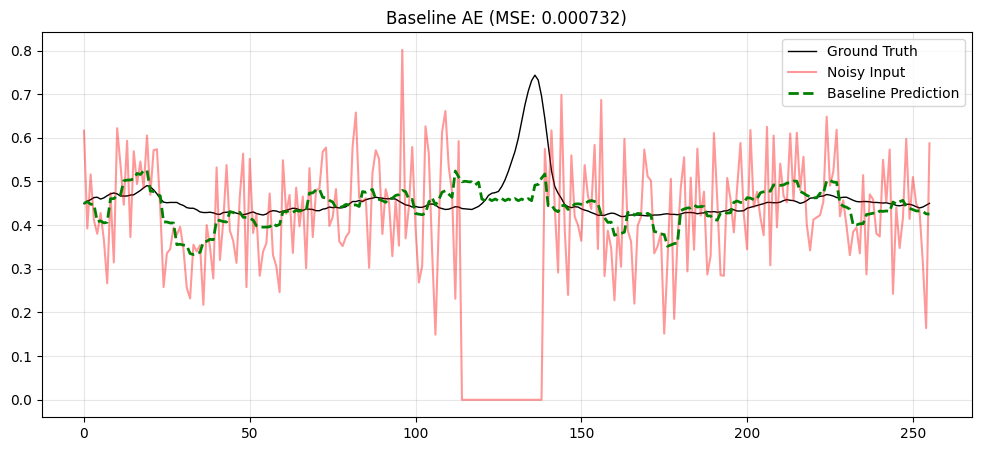

In [6]:
# Load Best Model
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "baseline_ae.pth")))
model.eval()

# 1. Compute Per-Sample Error (Fix 4)
all_errors = []

print("Computing per-sample validation errors...")
with torch.no_grad():
    for noisy, clean in val_loader:
        noisy, clean = noisy.to(CONFIG['device']), clean.to(CONFIG['device'])
        output = model(noisy)

        # Calculate MSE per sample (not averaged over batch yet)
        # Shape: (Batch, 1, 256) -> (Batch)
        loss_per_sample = torch.mean((output - clean)**2, dim=[1, 2])
        all_errors.append(loss_per_sample.cpu())

# Concatenate all batches
all_errors = torch.cat(all_errors)
print(f"✅ Computed errors for {len(all_errors)} validation samples.")
print(f"   Mean MSE: {all_errors.mean():.6f}")
print(f"   Max MSE:  {all_errors.max():.6f}")

# Save for Phase 3/4 comparison
torch.save(all_errors, os.path.join(PROJECT_ROOT, "results/metrics/baseline_errors.pt"))

# 2. Visual Sanity Check
# Get a specific sample
noisy, clean = val_dataset[5]
input_tensor = noisy.unsqueeze(0).to(CONFIG['device'])
with torch.no_grad():
    denoised = model(input_tensor).cpu().squeeze()

plt.figure(figsize=(12, 5))
plt.plot(clean[0], 'k', label="Ground Truth", linewidth=1)
plt.plot(noisy[0], 'r', alpha=0.4, label="Noisy Input")
plt.plot(denoised, 'g--', linewidth=2, label="Baseline Prediction")
plt.title(f"Baseline AE (MSE: {all_errors[5]:.6f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# --- FINAL TEST SET EVALUATION (CORRECTED & DETERMINISTIC) ---

# 1. Load Test Data
TEST_PATH = os.path.join(PROJECT_ROOT, "data/processed/test_clean.pt")

# Define Scenarios
test_dataset_standard = NoisyECGDataset(TEST_PATH, noise_level=0.1, mask_prob=0.1)
test_dataset_clean = NoisyECGDataset(TEST_PATH, noise_level=0.0, mask_prob=0.0)
test_dataset_extreme = NoisyECGDataset(TEST_PATH, noise_level=0.5, mask_prob=0.3)

# 🔧 FIX: Use the global seed generators defined in Cell 1
loaders = {
    "Clean": DataLoader(
        test_dataset_clean, batch_size=64, shuffle=False,
        worker_init_fn=seed_worker, generator=g_cuda
    ),
    "Standard": DataLoader(
        test_dataset_standard, batch_size=64, shuffle=False,
        worker_init_fn=seed_worker, generator=g_cuda
    ),
    "Extreme": DataLoader(
        test_dataset_extreme, batch_size=64, shuffle=False,
        worker_init_fn=seed_worker, generator=g_cuda
    )
}

results = {}

print("📊 Establishing Baseline Robustness (Deterministic)...")
print("ℹ️ Note: 'Extreme' scenario combines high noise (0.5) AND high masking (30%).")

model.eval()
with torch.no_grad():
    for name, loader in loaders.items():
        all_errors = []
        for noisy, clean in loader:
            noisy, clean = noisy.to(CONFIG['device']), clean.to(CONFIG['device'])
            output = model(noisy)

            # Compute MSE per sample
            loss_per_sample = torch.mean((output - clean)**2, dim=[1, 2])
            all_errors.append(loss_per_sample.cpu())

        # Aggregate
        all_errors = torch.cat(all_errors)
        mean_mse = all_errors.mean().item()
        results[name] = mean_mse

        # Save Standard errors for later calibration comparison
        if name == "Standard":
            torch.save(all_errors, os.path.join(PROJECT_ROOT, "results/metrics/baseline_test_errors.pt"))

# Print the Table
print("\n🏆 BASELINE PERFORMANCE (MSE)")
print("-" * 35)
print(f"1. Ideal (Noise 0.0):   {results['Clean']:.6f}")
print(f"2. Standard (Noise 0.1): {results['Standard']:.6f}  <-- BEAT THIS")
print(f"3. Extreme (Noise 0.5):  {results['Extreme']:.6f}")
print("-" * 35)
print("✅ Baseline frozen. Proceed to Phase 3.")

📊 Establishing Baseline Robustness (Deterministic)...
ℹ️ Note: 'Extreme' scenario combines high noise (0.5) AND high masking (30%).

🏆 BASELINE PERFORMANCE (MSE)
-----------------------------------
1. Ideal (Noise 0.0):   0.000266
2. Standard (Noise 0.1): 0.001297  <-- BEAT THIS
3. Extreme (Noise 0.5):  0.047423
-----------------------------------
✅ Baseline frozen. Proceed to Phase 3.
